# Bayesian optimization

## Authors:

    - Sara Munafò
    - Gloria Isotton
    - Carlo Divari
    
## Abstract
This work explores the application of Bayesian optimization to optimize one-dimensional and two-dimensional functions with known analytical forms. We then extend this approach to a simple image classification algorithm in machine learning.


# 1. Introduction and preliminaries
 Bayesian optimization is a powerful approach for optimizing time-demanding objective functions. It operates by constructing a surrogate model, typically employing Gaussian process regression, to approximate the true objective function. This surrogate model not only provides predictions of the objective function but also quantifies the uncertainty associated with those predictions.

The central idea of Bayesian optimization is to iteratively select new points for evaluation based on an acquisition function, which is derived from the surrogate model. The acquisition function balances the exploration of uncertain regions in the search space with the exploitation of promising areas where the objective function is likely to be optimal.

By iteratively updating the surrogate model based on the observed evaluations and selecting new points for evaluation using the acquisition function, Bayesian optimization efficiently explores the search space and converges to the optimal solution while minimizing the number of costly evaluations of the objective function. This makes it particularly well-suited for optimizing black-box functions under constraints such as limited evaluation budget and lack of derivative information.

## 1.1 Problem definition
We focus on solving the problem:

$$max_{x∈\mathcal{X}} f (x),
$$

where the feasible set and objective function typically have the following properties:


- Dimensionality: $ x \in \mathbb{R}^d $, typically with $ d \leq 20 $.
- Continuity: The objective function $ f $ is continuous, which is necessary for modeling $ f $ using Gaussian process regression.
- Expensive Evaluation: $ f $ is "expensive to evaluate", meaning the number of evaluations is limited, typically to a few hundred. This limitation arises due to time, cost (monetary or opportunity), or other resource constraints.
- Lack of Special Structure: $ f $ lacks known special structure like concavity or linearity, making it challenging to optimize efficiently using techniques leveraging such structure. It is termed a "black box" function.
- Derivative-Free: Observations of $ f(x) $ are made without access to first- or second-order derivatives, preventing the application of first- and second-order methods like gradient descent, Newton’s method, or quasi-Newton methods. This is referred to as "derivative-free" optimization.
- Noise-Free Observations: Observations of $ f(x) $ are made without noise.

## 1.2 Bayesian optimizaion

Algorithm: Bayesian optimization with Gaussian process model

0. Initialize the algorithm with a sample of $n$ values ${(x,y)}^{init}$
1. for $n = 1, 2, ...$ do
    2.    select new $x_{n+1}$ by optimizing acquisition function $\alpha$
    3.    $x_{n+1} = arg \hspace{0.1cm}max_x \alpha (x; D_n)$
    4.    query objective function to obtain $y_{n+1}$
    5.    augment data $D_{n+1} = D_n ∪ {(x_{n+1}, y_{n+1})}$
    6.    update statistical model, fitting the data to a Gaussian process model 
7. end for


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go # Plotly for 3D interactive plots
from PIL import Image             # PIL for image manipulation
import os
import imageio                    # Imageio for reading and writing image data
from IPython.display import display
from IPython.display import display, Image
from sklearn.gaussian_process import GaussianProcessRegressor # Scikit-learn for Gaussian process regression
from sklearn.gaussian_process.kernels import Matern           # Scikit-learn for Matern kernel
np.random.seed(42)                                            # Set random seed for reproducibility

from sklearn.neural_network import MLPClassifier   # Classification problem
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## 1.3 Blackbox known function 

We've opted to validate our implementation by testing it on two established functions. We proceed by computing the maximum value of these functions within a predetermined range and verifying if it aligns with the established values. <br>
To commence, we'll import these functions from the library and generate plots for visual analysis.


In [2]:
# import the BlackBox Class from the library
from BYO_library import BlackBox 

# initialize the BlackBox Class as 'my_blackbox'
my_blackbox = BlackBox()

# initialize the number of points in the grid
n = 50    # for Branin
n2 = 100  # for the simple function

### 1.3.1 A simple function

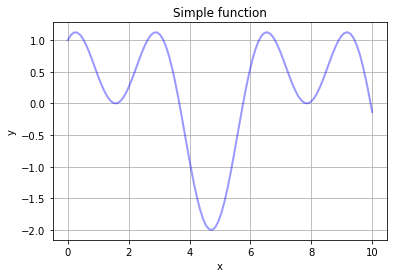

In [3]:
# Using the simple function
simple_f = my_blackbox.simple_func(np.linspace(0,10,n2))

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

### 1.3.2 The Branin Function

In [4]:
# Using the branin function
x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) 
z = my_blackbox.branin(x1, x2, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)

# Create a plotly interactive graph
fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=z, colorscale='viridis')]) # type: ignore

fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis'),
                    yaxis=dict(title='Y Axis'),
                    zaxis=dict(title='Z Axis')),
                    title='Branin function 3D Plot',
                    autosize=False,
                    width=800,
                    height=600,
                    margin=dict(l=65, r=50, b=65, t=90))

# Display the plot
fig.show()

# 2. Acquisition function

In this section we explain the precise process or strategy for choosing the order of query points $x_{1:n}$. While random selection is an option, it's inefficient. Instead, various strategies in literature use the posterior model to guide the sequential search, determining the next query point $x_{n+1}$ based on $\mathcal{D}_n=\{(x_1,y_1),...,(x_n,y_n)\}$.

Acquisition functions are designed to balance between exploring new areas of the search space and exploiting the current promising areas.

Once an acquisition function is employed to identify the next hyperparameter, the actual score of this new hyperparameter based on the true objective function is acquired. Because the surrogate model has been trained on pairs of (hyperparameter, true objective function score), incorporating a new data point updates the surrogate model.

In the following we will consider x, the query point, its corresponding function value $\nu = f(x)$ and the model hyperparameters $\theta$. We will marginalize the unseen outcome y and the unknown model hyperparameters $\theta$.

## 2.1 PI acquisition function
Probability of improvement acquisition function is an improvement-based acquisition function, meaning that it favors points that are likely to improve upon a certain time.
This function measures the probability that a point x leads to an improvement upon $\tau$ (the target value, in our case the best estimate of the maximum of the function). We can analytically compute this probability as follows:
$$
\alpha_{PI}(x;\mathcal{D}_n) := \mathcal{P}[\nu > \tau] = \Phi\left(\frac{\mu_n(x) - \tau}{\sigma_n(x)}\right)
$$

where $\Phi$ is the standard normal cumulative distribution function. As we can see from the formula PI considers the difference between the mean prediction and the current best value, taking into account the uncertainty in the surrogate model. $\alpha_{PI}(x;\mathcal{D}_n)$ is then maximized to select the next query point.

## 2.2 EI acquisition function
PI is often a good solution for the choice of the acquisition function when the target is known; in general, however the heuristic used for an unknown target causes PI to exploit quite aggressively.    
We can consider a differen acquisition function (EI).    
This new criterion corresponds to a different utility function,the improvement function, denoted by $I(x)$, which is defined as follows: 
$$I(\text{x}, \nu,\theta)=(\nu-\tau)\mathbb{I}(\nu>\tau)$$
and it has positive value only if there is an improvement. Since $\nu$ is normally distributed, the *expectation of improvement* can be computed as:
$$\alpha_{EI}(\text{x},\mathcal{D}_n)=\mathbb{E}[I(\text{x}, \nu,\theta)]=(\mu_n(\text{x}-\tau))\Phi \left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right)  + \sigma_n(\text{x})\phi\left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right) $$
when $\sigma_n>0$ (it vanishes otherwise); in this expression:
- $\Phi$ is the standard normal cumulative distribution function
- $\phi$ is the standard normal probability distribution function.    
    
    

>*Note on the parameter $\tau$*:
>although the target value (the best reachable objective value) is often unknown, in practice $\tau$ is adaptively set to be the best observed value ($\tau=y^+=max_{i=1:n}y_i$)


#### Import acquisition functions

In [5]:
# Probability of improvement acquisition function
from BYO_library import prob_i

# Expected improvementa cquisition function
from BYO_library import expected_i


# 3. Handling Hyperparameters

The Hyperparameters of the model are represented by the vector $\theta$: <br>

$$\theta = [\theta_0,\theta_i], \quad i=1,..,d$$ 

It follows that we have $d+1$ total hyperparameters:
- $1 \rightarrow \theta_0$ is the square root of the multiplication constant of the kernel;
- $d \rightarrow \theta_i$ ($i=1,..d$) are the length scales.

>Note on the hyperparameters $\theta$:<br>
> It's important to recognize that the hyperparameters discussed above are specifically related to the kernel of the gaussian process regressor. They are not the parameters that are traditionally known as machine learning hyperparameters. <br>
>When employing Bayesian optimization for a classification algorithm, we typically encounter parameters such as learning rate, batch size, and the number of layers in the neural network. Those are usually referred to as hyperparameters in machine learning. <br>
In our application we will call these numbers (learning rate, batch size, number of layers in the network ..) with symbol '$x$'. This is because the negative loss function must be maximized across the space defined by these parameters (parameters that are essentially equivalent to what's traditionally known as machine learning hyperparameters).
In summary kernel parameters $\theta \neq [\text{learning rate}, \text{batch size},...]$

### 3.1 Maximum likelihood

Maximum likelihood is a data-driven approach to handling kernel hyperparameters. It is also known as point estimation. We want to sample from the posterior distribution:$$ p(\theta | D_n) = \frac{p(y | X, \theta)p(\theta)}{p(D_n)} $$
where:

- $ p(y | X, \theta) $ represents the likelihood of the data given the hyperparameters;
- $ p(\theta) $ represents the prior distribution of the hyperparameters;
- $ p(D_n) $ is the evidence.

The estimators $ \hat{\theta}_\text{ML} $ and $ \hat{\theta}_\text{MAP} $ can be obtained by optimizing the marginal likelihood or the unnormalized posterior, respectively:

$$
\begin{aligned}\log p(\mathbf{y}|\mathbf{x}_{1:n},\theta)&=-\frac{1}{2}\left(\mathbf{y}-\mathbf{m}_{\theta}\right)^{T}\left(\mathbf{K}^{\theta}+\sigma^{2}\mathbf{I}\right)^{-1}(\mathbf{y}-\mathbf{m}_{\theta})\\&-\frac{1}{2}\log|\mathbf{K}^{\theta}+\sigma^{2}\mathbf{I}|-\frac{n}{2}\log(2\pi)\end{aligned}
$$


In practice we just set the `optimizer=="fmin_l_bfgs_b"`of the gaussian process regressor.

### 3.2 Sequential Monte-Carlo    

In SMC we iteratively update a sample of size N, using information from the data to approximate better the posterior.    
The basic Idea is the following:
 1. Obtain a sequence of samples of theta distributed approximately as the posterior
 2. average the acquisition function over those samples
 
SMC takes care of the first point. If we want to sample from the posterior distribution $p(\theta,D_n)$, this distribution is not easily integrabel and the dependencies on $\theta$ are not trivial.    
We can then make use of the so called **Importance Sampling** technique.    
We approximate $$p(\theta|D_n) \simeq w(\theta) \pi(\theta|D_n)$$
where
- $\pi(\theta|D_n)$ importance sampling density: can have different forms, often a delta distribution;
- $w(\theta)$ : importance sampling weight: associates an 'importance'to each value of $\theta$ based on maximum likelihood 
With this approximation, we can write: $$E_{\theta|D_n}[\alpha(x,\theta)]=\int \alpha(x,theta)p(\theta|D_n)d\theta \simeq \sum_{i=1}^N \alpha(\theta^{(i)})w_t^{(i)}$$

(averaged over $N$ samples of the hyperparameters).
The goodness of this algorithm resides on taking a good sample of hyperparameters, which is therefore determined by the appropriate weights. Here follows the algorithm:

Given:
- $p(\theta_0)$ : prior of hyperparameters
- $p(\theta_t|\theta_{t-1})$ : prior of transition probabilities
- $p(y_t|\theta)=\dfrac{e^{-\dfrac{1}{2}(y_t K(\theta)^{-1})y_t}}{\sqrt{|2\pi K(\theta)|}}$  likelihood of inferred $y_t$ given a set of hyperparameters

We proceed as follows:

> 1. Before training: initialize a sample of size N (same size of x and y) of hyperparameters according to the prior distribution   <br>
> 2. For each iteration t of training:    
    >- For $i=0,...,N-1$    
    >   - #add a new sample of N hyperparameters, one by one    
    >   - $\theta_t^{(i)}\sim p(\theta_t^{(i)}|\theta_{t-1}^{(i)})$    
        
>$\theta_{0:t}=[\theta_{0:t-1},\theta_t]$   
    >- For $i=0,...N-1$:    
    >   -  #compute weights with likelihood    
        >$w_t^{(i)}=p(y_t|\theta_t^{(i)})$       ($y_t$ is the best y obtained in the training iteration)    
        >Substitute the 'layer' t of hyperparameters by resampling N hyperparameters (one by one) using the weights

    
    

**Note on the function below**:
the kernel has to be a semidefinite positive matrix: if one of the hyperparameters is $<0$ it doesn't work, it returns nan and it doesn't do anything;  the problem is that, since we choose theta at each $t$ from a gaussian which can be centered anywhere, we may also have negative values; The problem is solved if we don't start with zero mean gaussians and we take a small variance.    
Also, in the 2D case, a scaling factor is added to the weights to avoid underflow.


In [6]:
# import sequential monte carlo optimization method for hyperparameters
from BYO_library import smc

# 4. Bayesian optimization applied to known functions

## 4.A) 1-Dimensional simple function

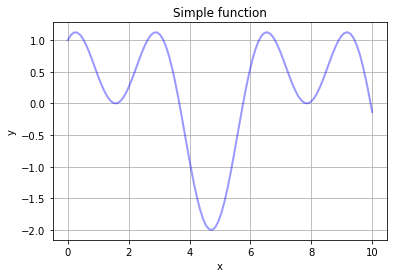

In [7]:
# Generate a grid and plot the simple function
x_grid = np.linspace(0,10,n2)
simple_f = my_blackbox.simple_func(x_grid)

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

##### Initial sampling

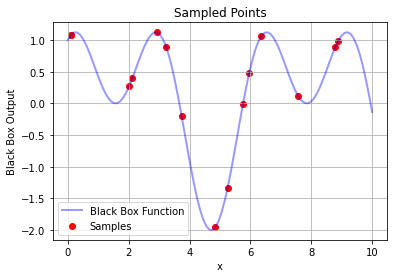

In [12]:
# Sample 15 outputs from function f
n_sample = 15
sample_x = np.random.choice(x_grid, n_sample)

# output for each sampled x value
sample_y =  my_blackbox.simple_func(sample_x)

# plot
plt.plot(x_grid, simple_f, label='Black Box Function',linewidth=2, color='blue', alpha=0.4)
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.grid()
plt.show()


#### Import functions for plots and gifs

In [13]:
from BYO_library import plot_1D
from BYO_library import make_gif

#### Function for training

In [14]:
from BYO_library import bysn_1D

### 4.A.1) Training with max likelihood

In [15]:
#display the evolution with expected improvment
N=T=var=0
num_iterations = 40
optimizer = "fmin_l_bfgs_b"
folder_path = '/home/carlo/Documenti/Informaton_Theory_and_Inference'
gif_name = 'simple_function_ml.gif'
gif_dur  = 0.5
acquisition = 0
final_x_ml, final_y_ml,loss_ml1= bysn_1D(x_grid, sample_x.reshape(-1,1), sample_y, my_blackbox, optimizer, num_iterations, acquisition,N,T,var, folder_path, gif_name, gif_dur)

Iteration number :  0
Iteration number :  10
Iteration number :  20
Iteration number :  30
Optimized theta:  1.37**2 * Matern(length_scale=2.19, nu=1.5)


<Figure size 720x432 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

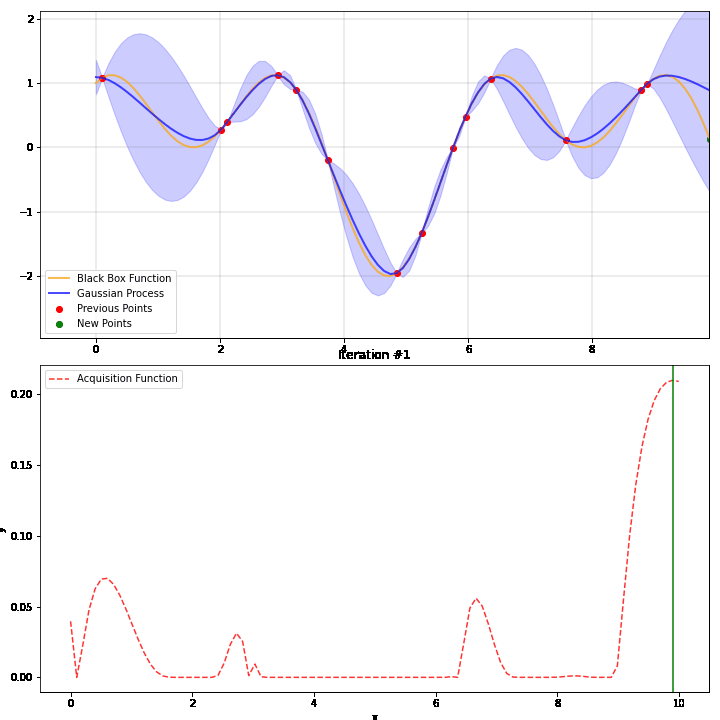

In [16]:
gif_path = os.path.join(folder_path, 'simple_function_ml.gif')
display(Image(filename=gif_path))

### A.2 : Training with Sequential monte Carlo

In [19]:
#display the evolution with expected improvment
num_iterations = 25
folder_path = '/home/carlo/Documenti/Informaton_Theory_and_Inference'
gif_name = 'simple_function_smc.gif'
acquisition = 0 #ei
optimizer = "smc"

In [20]:
#best values from max likelihood /100
#variances of Gaussians
var = [1.27/100,2.02/100]

N = 100
T = 25
k_dim = 2

final_x_smc,final_y_smc, loss_smc1 = bysn_1D(x_grid, sample_x.reshape(-1,1), sample_y, my_blackbox, optimizer, num_iterations, acquisition,N,T,var, folder_path, gif_name, gif_dur)

Iteration number :  0


Iteration number :  10
Iteration number :  20
Optimized theta:  1**2 * Matern(length_scale=1, nu=1.5)


<Figure size 720x432 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

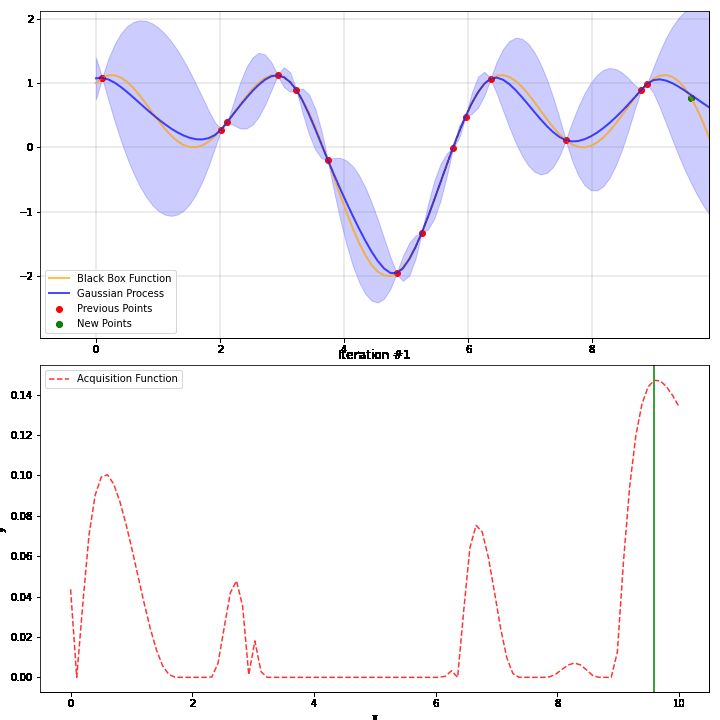

In [21]:
gif_path = os.path.join(folder_path, 'simple_function_smc.gif')
display(Image(filename=gif_path))

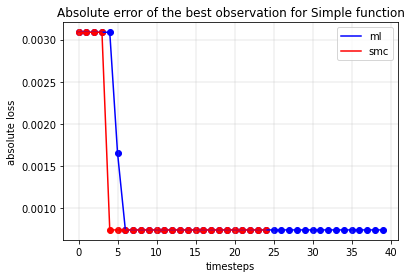

In [22]:
plt.plot(np.arange(0,len(loss_ml1)),loss_ml1, color = 'blue',label='ml')
plt.scatter(np.arange(0,len(loss_ml1)),loss_ml1, color = 'blue')
plt.grid('..', linewidth=0.3)
plt.plot(np.arange(0,len(loss_smc1)),loss_smc1, color = 'red',label='smc')
plt.scatter(np.arange(0,len(loss_smc1)),loss_smc1, color = 'red')
plt.xlabel('timesteps')
plt.ylabel('absolute loss')
plt.title('Absolute error of the best observation for Simple function')
plt.legend()

## 4.B) 2-Dimensions : Branin function

#### Initial Sampling

In [23]:
def sampling(x1: np.ndarray, x2: np.ndarray, n_sample: int, a: float, b: float, c: float, r: float, s: float, t: float )-> tuple[np.ndarray, np.ndarray]:
    """
    Args:
        x1 (np.ndarray): data points
        x2 (np.ndarray): data points
        n_sample (int): number of points to be sampled
        a, b, c, r, s, t (float): paramters of Branin Function 

    Returns:
        tuple[np.ndarray, np.ndarray]: data points sampled 
    """
    s_x = np.zeros((n_sample,2), dtype=float)
    s_x[:,0] = np.random.choice(x1[0,:], n_sample)
    s_x[:,1] = np.random.choice(x2[:,0], n_sample)
    s_z = np.zeros_like(s_x, dtype=float)
    s_z = my_blackbox.branin(s_x[:,0], s_x[:,1], a=a, b=b, c=c, r=r, s=s, t=t)
    return s_x, s_z


In [24]:
n = 50

x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) # grid of points
n_sample = 30
sample_x, sample_y = sampling(x1, x2, n_sample, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)

#### Function for plotting 2D surface variance

In [25]:
from BYO_library import plot_3d_surface_variance

#### Function for optimization

In [26]:
from BYO_library import bysn_2d    

### B.1 : Training with max likelihood

In [27]:
optimizer = "fmin_l_bfgs_b"
num_iterations = 20
acquisition = 0 #(use expected improvement)
N=T=var=k_dim=0 #no smc
folder_path = '/home/carlo/Documenti/Informaton_Theory_and_Inference'
name='MaxLIke_Branin.png'

In [28]:
x_2d_ml, y_2d_ml, loss_ml2= bysn_2d(sample_x, sample_y, x1, x2, my_blackbox, optimizer, num_iterations, acquisition, folder_path, name)

Iteration number :  0
Iteration number :  10
Optimized theta:  316**2 * Matern(length_scale=[17.6, 49.7], nu=1.5)


In [29]:
index = np.argmax(y_2d_ml)
best_x = x_2d_ml[index,:]
best_y = y_2d_ml[index]
print("The maximum value found is : ", best_y, "at coordinates : ", best_x)

The maximum value found is :  308.12909601160663 at coordinates :  [-5.  0.]


### B.2 : Training with sequential Monte Carlo

In [43]:
k_dim = 3
N = 100
T = 25
var = [316/100,18.2/100,46/100]
optimizer = "smc"
num_iterations = 20
acquisition = 0 #(use expected improvement)

In [ ]:
x_2d_smc, y_2d_smc, loss_smc2 = bysn_2d(sample_x, sample_y, x1, x2, my_blackbox, optimizer, num_iterations, acquisition, folder_path, name, N,T,var)

Iteration number :  0
Iteration number :  10
Optimized theta:  52.1**2 * Matern(length_scale=[9.92, 11.4], nu=1.5)


In [ ]:
index = np.argmax(y_2d_smc)
best_x = x_2d_smc[index,:]
best_y = y_2d_smc[index]

print("The maximum value found is : ", best_y, "at coordinates : ", best_x)

The maximum value found is :  308.12909601160663 at coordinates :  [-5.  0.]


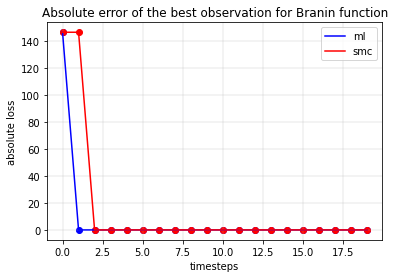

In [ ]:

plt.plot(np.arange(0,len(loss_ml2)),loss_ml2, color = 'blue',label='ml')
plt.scatter(np.arange(0,len(loss_ml2)),loss_ml2, color = 'blue')
plt.grid('..', linewidth=0.3)
plt.plot(np.arange(0,len(loss_smc2)),loss_smc2, color = 'red',label='smc')
plt.scatter(np.arange(0,len(loss_smc2)),loss_smc2, color = 'red')
plt.xlabel('timesteps')
plt.ylabel('absolute loss')
plt.title('Absolute error of the best observation for Branin function')
plt.legend()

# 5. Bayesian optimization applied to Multi-Layer-Perceptron

After testung our algorithm with simple known function, we can try to apply it to a real case: the optimization of the hyperparameters of a Multi-layer perceptron in the classification task. In this case, our blackbox function is the score of the MLP in a specific classification task, which is dependent on the choice of the hyperparameters.   
In general, a Neural network has a set of hyperparameters; for our experiment, we only focus on optimizing one or two of these hyperparameters at a time, keeping fixed all the others.    

### Loading the dataset
The MLP will try to classify data from the K-MNIST dataset: a set of 6000 samples of greyscale images of handwritten numbers.

In [11]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [12]:
np.random.seed(2072380)

In [13]:
#load the MNIST dataset and normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000


In order to train the MLP we need tosplit into training and test.    
We choose a training set of 600 samples to reduce computation time, while 4000 samples will be used for testing. 

In [14]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]


#Make sure that each label is present at least 10 times to have a representative set
labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [52 55 49 57 63 61 58 77 69 59]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [52 55 49 57 63 61 58 77 69 59]


With the following plot function, we can visualize an example of a sample from the dataset and its label:

In [15]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


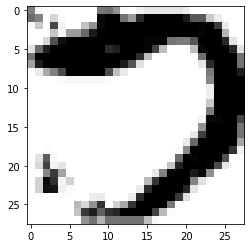

LABEL: 3


In [16]:
#let's try the plotting function
plot_input(X_train,y_train,10)

## 5.A) 1-dimension: Optimizing learning rate
Our neural network architecture is given by the function 'nn.MLPClassifier', and in the 1 dimensional case we choose to optimize the learning rate.    
If the learning rate is constant (which it is by default, unless specified otherwise), its value is given by the 'learning_rate_init' parameter in the function; all the other parameters are kept fixed, in detail:
- max_iter = 100 : maximum epochs for training
- solver ='sgd' : Stochastic Gradient Descent is used as optimizer
- batch_size : 200
- hidden_layer_sizes=(20,20) : two layers with 20 neurons each


In this case, the blackbox function we want to maximize is the **score** function. Its values, given the values of the hyperparameters, are returned by the 'blackbox_mlp' function of our library.

In [17]:
from BYO_library import blackbox_mlp

#### Initial sampling

In [18]:
#Choose a reasonable grid
x_grid = np.linspace(1e-3,2,1000)

#Initial sampling
n_sample = 30
sample_x = np.random.choice(x_grid, n_sample).reshape(-1,1)

# output for each sampled x value
sample_y = np.zeros((n_sample))
for i in range(len(sample_x)):
    sample_y[i] = blackbox_mlp(sample_x[i], X_train,y_train, X_test,y_test)

#### Optimization

In [19]:
from BYO_library import optimize_MLP
import time

In [20]:
#Set all parameters

num_iterations = 100
folder_path = '/home/sara/Scrivania/Physics_of_Data/2nd_Year/Information_theory'
acquisition = 0 #ei
name= 'mlp_1d.gif'

var = [0.603/100,2.02/100]

N = 100
T = 25
x1=x2=0 #not needed in 1d
gif_dur = 0.1

In [21]:
#Optimize


x_1d_nn,y_1d_nn = optimize_MLP(x_grid,sample_x,sample_y,x1, x2, X_train,y_train, X_test,y_test, num_iterations, acquisition,
                   N, T, var, folder_path, name, gif_dur)


Iteration number :  0
Iteration number :  10
Iteration number :  20
Iteration number :  30
Iteration number :  40
Iteration number :  50
Iteration number :  60
Iteration number :  70
Iteration number :  80
Iteration number :  90
Optimized theta:  10**2 * Matern(length_scale=10, nu=1.5)


<Figure size 720x432 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

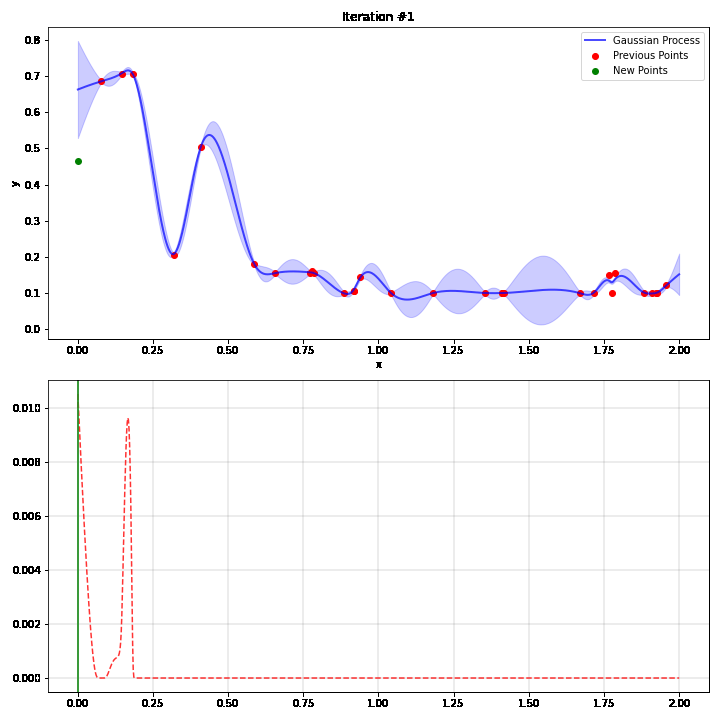

In [22]:
gif_path = os.path.join(folder_path, 'mlp_1d.gif')
display(Image(filename=gif_path))

In [23]:
index_1 = np.argmax(y_1d_nn)
print('Optimized learning rate: ','%.3f' % x_1d_nn[index_1], 'with a score of: ', y_1d_nn[index_1], '\n')

Optimized learning rate:  0.157 with a score of:  0.71725 



## 5.B) 2-dimensions: Optimizing (learning rate, batch size)


We choose as second hyperparameter the size of the batch used for the optimization with SGD.   

In this experiment, to find a good compromise between not having too many points on the 2D grid and not leaving too much space between two consecutive values of the grid, we reduced the interval of values for the learning rate from $[10^{-3},2]$ to $[10^{-2},1]$;    
The batch size ranges from $1$ to the size of the full training dataset, with steps of  $10$.

The number of initial samples was increased to $120$, to maintain the ratio of known samples vs. possible values ($60^2$) of the same order of magnitude of the one-dimensional case, as well as the number of iterations.

In [41]:
n = 60
x1,x2 = np.meshgrid( np.linspace(1e-2, 1, n, dtype=float),
                     np.linspace(1,600, n, dtype=int)) 
x_grid = np.column_stack((x1.ravel(),x2.ravel()))

#### Initial sampling

In [42]:
#Initial sampling
n_sample = 120

sample_x = np.zeros((n_sample,2), dtype=float)
sample_x[:,0] = np.random.choice(x1[0,:], n_sample)
sample_x[:,1] = np.random.choice(x2[:,0], n_sample)

In [43]:
sample_y = np.zeros(n_sample, dtype=float)
for i in range(n_sample):
    sample_y[i] = blackbox_mlp(sample_x[i,:], X_train,y_train,X_test,y_test)

#### Optimization

In [45]:
import kaleido #for 2d plot

# Set all parameters

N = 100
T = 25
var = [0.5/100,0.5/100,0.5/100]
num_iterations = 300
acquisition = 0 #(use expected improvement)
gif_dur=0       #no gif in 2d
name = 'surface_nn_2d_300.png'
folder_path = '/home/sara/Scrivania/Physics_of_Data/2nd_Year/Information_theory'

In [46]:

x_2d_nn,y_2d_nn = optimize_MLP(x_grid,sample_x,sample_y,x1,x2,X_train,y_train,X_test,y_test,num_iterations, acquisition, 
                    N, T, var, folder_path, name, gif_dur)

Iteration number :  0
Iteration number :  10
Iteration number :  20
Iteration number :  30
Iteration number :  40
Iteration number :  50
Iteration number :  60
Iteration number :  70
Iteration number :  80
Iteration number :  90
Iteration number :  100
Iteration number :  110
Iteration number :  120
Iteration number :  130
Iteration number :  140
Iteration number :  150
Iteration number :  160
Iteration number :  170
Iteration number :  180
Iteration number :  190
Iteration number :  200
Iteration number :  210
Iteration number :  220
Iteration number :  230
Iteration number :  240
Iteration number :  250
Iteration number :  260
Iteration number :  270
Iteration number :  280
Iteration number :  290
Optimized theta:  10**2 * Matern(length_scale=[10, 10], nu=1.5)


Here follows a 3d representation of the surface approximated by the algorithm:

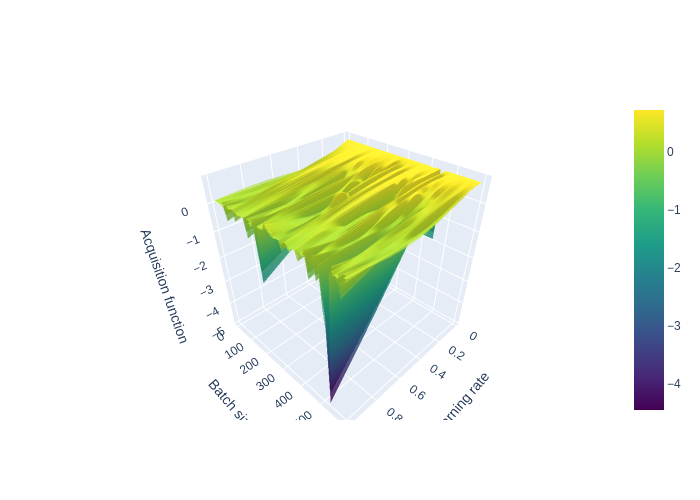

In [48]:
index_2 = np.argmax(y_2d_nn)
print('Optimized learning rate and mini-batch size: [','%.3f' % x_2d_nn[index_2][0], ' , ', int(x_2d_nn[index_2][1]), '] ','with a score of: ', y_2d_nn[index_2])

Optimized learning rate and mini-batch size: [ 0.178  ,  204 ]  with a score of:  0.7165


## 5.C) Grid-search test

In order to have a measure of comparison, we tried to compare the results obtained with Bayesian optimization with the results obtained by applying one of the most common alternatives used to optimize the hyperparameters, the **GridSearch**.    
The GridSearch algorithm evaluates the value of the score of the MLP in each of the possible values chosen as candidates for the hyperparameters.     
    

Our comparison is not focused on the execution time, since our algorithm is probably not optimized in the best possible way, but rather to use GridSearch as a 'confirmation' that the values obtained from the Bayesian optimization as optimal values are actually consistent with the results of a well known optimization algorithm.    

We kept the number of points and the extremes of the intervals on which to evaluate the score equal to the ones used with Bayesian optimization, in order to see how close the results produced by the Bayesian algorithm are to the actual optimal results.

### 1-dimensional case

In [71]:
#Possible parameters values
n = 1000
parameters = {'learning_rate_init': list(np.linspace(1e-3, 2, n, dtype=float))}

#Multi layer perceptron with same architecture used above
mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=2072380,
                    learning_rate_init=.1,hidden_layer_sizes=(20,20))

In [72]:
start = time.time()
cross_val = GridSearchCV(mlp, parameters, scoring=None, n_jobs=None, refit=True, cv=5)
cross_val.fit(X_train,y_train)
cross_val.predict(X_test)
end = time.time()

print('Time for execution: ',end - start, 's')

Time for execution:  248.23154878616333 s


In [78]:
print('\n')
print('BAYESIAN OPTIMIZATION:  Best learning rate: ','%.3f'%x_1d_nn[index_1] ,' Best score: ', '%.3f'%y_1d_nn[index_1], '\n')
print('GRIDSEARCH:             Best learning rate: ','%.3f'%cross_val.best_params_['learning_rate_init'], ' Best score : ', '%.3f'%cross_val.best_score_, '\n')



BAYESIAN OPTIMIZATION:  Best learning rate:  0.157  Best score:  0.717 

GRIDSEARCH:             Best learning rate:  0.171  Best score :  0.752 



### 2-dimensional case

In [79]:
#Possible parameters values
n = 60
parameters = {'learning_rate_init': list(np.linspace(1e-2, 1, n, dtype=float)),'batch_size':list(np.linspace(1,600, n, dtype=int)) }

#Multi layer perceptron with same architecture used above
mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=2072380,
                    learning_rate_init=.1,hidden_layer_sizes=(20,20))

In [80]:
start = time.time()
cross_val = GridSearchCV(mlp, parameters, scoring=None, n_jobs=None, refit=True, cv=5)
cross_val.fit(X_train,y_train)
cross_val.predict(X_test)
end = time.time()

print('Time for execution: ',end - start, 's')

Time for execution:  3526.1802084445953 s


In [81]:
print('\n')
print('BAYESIAN OPTIMIZATION:  Best batch size: ',int(x_2d_nn[index_2][1]),' Best learning rate: ','%.3f' % x_2d_nn[index_2][0],' Best score: ','%.3f'% y_2d_nn[index_2], '\n')
print('GRIDSEARCH:             Best batch size: ',cross_val.best_params_['batch_size'],' Best learning rate: ','%.3f'%cross_val.best_params_['learning_rate_init'], ' Best score : ', '%.3f' % cross_val.best_score_, '\n')



BAYESIAN OPTIMIZATION:  Best batch size:  204  Best learning rate:  0.178  Best score:  0.717 

GRIDSEARCH:             Best batch size:  143  Best learning rate:  0.111  Best score :  0.750 



### Note on the results


The results obtained by employing the GridSearch algorithm are comparable to the ones obtained from the Bayesian Optimization algorithm.    
Even if we didn't focus on time comparison, it is worth to note that, while in 1D we observed that the GridSearch outperformed the Bayesian optimization in terms of execution time, the opposite is true in 2D, where the execution time of the GridSearch was more than twice the one of the Bayesian Optimization, with comparable results in terms of score and parameters.    
We didn't measure the exact time of execution for the Bayesian optimization, but these empirical results could be further analyzed in the future, to better improve our work.